# Deep-Dream Pytorch implementation




For more insights we recommend:


*   https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html
*   Listeneintrag




This implementatio was adapted from: https://github.com/duc0/deep-dream-in-pytorch



In [8]:
import torch
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from PIL import Image, ImageFilter, ImageChops

Program configs

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("running with: ",device)


running with:  cuda


Deep Dream using VGG19

In [10]:
class DeepDream:
    def __init__(self, image):
        self.image = image
        self.model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True).to(device=device)
        self.modules = list(self.model.features.modules()) #save a list of modules to iterate later on to get activations
        
        # vgg uses 224*224 and normalized images
        imgSize = 224
        self.transformMean = [0.485, 0.456, 0.406]
        self.transformStd = [0.229, 0.224, 0.225]
        self.tensorMean = torch.Tensor(self.transformMean).to(device=device)
        self.tensorStd = torch.Tensor(self.transformStd).to(device=device)

        self.transformNormalise = transforms.Normalize(
            mean=self.transformMean,
            std=self.transformStd
        )
        
        self.transformPreprocess = transforms.Compose([
            transforms.Resize((imgSize, imgSize)),
            transforms.ToTensor(),
            self.transformNormalise
        ])
        


    def toImage(self, input):
        return input * self.tensorStd + self.tensorMean

### Main deep dream algorithm
Input 
* an input image
* layerId
* number of iterations

Makes a forward pass until layerId, computes the gradient and updates the input image. Here we maximize the layer activation. This is repeated for the given number of iterations.


In [11]:
class DeepDream(DeepDream):
    def deepDream(self, image, layer, iterations, lr):

        #transform the image and set autograd to true
        transformed = self.transformPreprocess(image).unsqueeze(0).to(device=device)
        input = torch.autograd.Variable(transformed, requires_grad=True)

        #forward the input through the modules specified above
        self.model.zero_grad()
        for _ in range(iterations):
            out = input
            for layerId in range(layer):
                out = self.modules[layerId + 1](out)
            loss = out.norm()
            loss.backward()
            input.data = input.data + lr * input.grad.data

        input = input.data.squeeze()
        input.transpose_(0,1)
        input.transpose_(1,2)
        input= self.toImage(input).cpu()
        input = np.clip(input, 0, 1)
        return Image.fromarray(np.uint8(input*255))

Recursively apply deepDream at different scales and blend the result images to make the final image looks better.

In [12]:
class DeepDream(DeepDream):
    def deepDreamRecursive(self, image, layer, iterations, lr, num_downscales):
        if num_downscales > 0:
            print("enter downscaling ", num_downscales)
            # scale down the image
            image_small = image.filter(ImageFilter.GaussianBlur(2))
            small_size = (int(image.size[0]/2), int(image.size[1]/2))            
            if (small_size[0] == 0 or small_size[1] == 0):
                small_size = image.size
            image_small = image_small.resize(small_size, Image.ANTIALIAS)
            
            # run deepDreamRecursive on the scaled down image
            image_small = self.deepDreamRecursive(image_small, layer, iterations, lr, num_downscales-1)
            
            # Scale up the result image to the original size
            image_large = image_small.resize(image.size, Image.ANTIALIAS)
            
            # Blend the two image
            image = ImageChops.blend(image, image_large, BLEND_ALPHA)

        img_result = self.deepDream(image, layer, iterations, lr)
        img_result = img_result.resize(image.size)
        return img_result
    
    def deepDreamProcess(self):
        return self.deepDreamRecursive(self.image, LAYER_ID, NUM_ITERATIONS, LR, NUM_DOWNSCALES)

Perform "deep dream" on it. Note that the computation could take a few minutes.

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


enter downscaling  10
enter downscaling  9
enter downscaling  8
enter downscaling  7
enter downscaling  6
enter downscaling  5
enter downscaling  4
enter downscaling  3
enter downscaling  2
enter downscaling  1


AttributeError: ignored

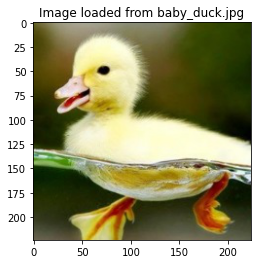

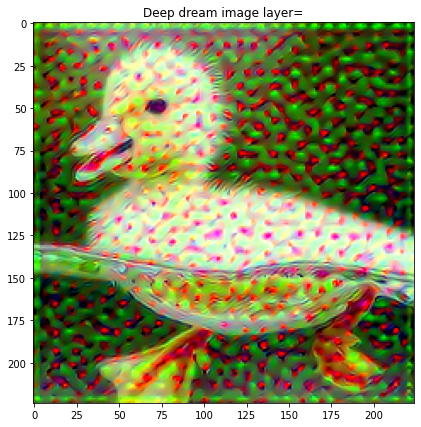

In [17]:
IMAGE_PATH = 'baby_duck.jpg'

# Deep dream configs
LAYER_ID = 7 # The layer to maximize the activations through. 
#You should give layers 7, 19 and 28 a try.

NUM_ITERATIONS = 10 # Number of iterations to update the input image with the layer's gradient. 
#You should give 10 iterations and 30 a try. 

LR = 0.2

# We downscale the image recursively, apply the deep dream computation, scale up, and then blend with the original image 
# to achieve better result.
NUM_DOWNSCALES = 10
BLEND_ALPHA = 0.6

img = Image.open(IMAGE_PATH).convert('RGB')

plt.imshow(img)
plt.title("Image loaded from " + IMAGE_PATH)




img_deep_dream = DeepDream(img).deepDreamProcess()
plt.figure(figsize = (7,7))
plt.imshow(img_deep_dream)
plt.title("Deep dream image layer=",LAYER_ID)
plt.show()

In [133]:
img_deep_dream.save('deepdream_' + IMAGE_PATH)

Print the VGG Model for layer selection



In [109]:
model_vgg= torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True)
print(model_vgg)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd